# CIFAR 10 Example
Since my experience until now has been mostly with Tensorflow/Keras, this notebook is intended to play around with PyTorch and run through their tutorial for training on the CIFAR10 dataset. In addition - it will be all done on the gpu.

### What is CIFAR 10?
Taken straight from the [website](https://www.cs.toronto.edu/~kriz/cifar.html):
"The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. 

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class."

### What is the goal?
As an introduction to PyTorch - use the tutorial, get its results and improve them.

### Project Structure:

1. Loading the data & Loading the libraries.
2. Showing a sample of images.
3. Defining and training a convolutional neural network.
4. Evaluating the results.
5. Improving the results.

...

### References
* [Learning Multiple Layers of Features from Tiny Images](https://www.cs.toronto.edu/~kriz/learning-features-2009-TR.pdf), Alex Krizhevsky
* [Training a classifier](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html), PyTorch

## 1. Loading the data & Loading the libraries.

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Set the device to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

First I will try to mimic the tutorial from Torch's website then implement it my way.

In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./datasets', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./datasets', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## 2. Showing a sample images.

truck horse horse  bird


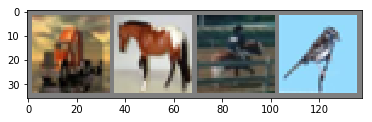

In [4]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 3. Defining a Convolutional Neural Network

In [5]:
import torch.nn as nn
import torch.nn.functional as F
# maybe define an object as input - architecture.
class Net(nn.Module):
    # nn.Conv2d(in_channels, out_channels, kernel_size)
    # nn.Linear(in_features, out_features, bias=True)
    # nn.MaxPool2d(kernel_size, stride=None)
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net().to(device)

### 3.1 Defining a Loss function and optimizer

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 3.2 Training the Network

In [7]:
def train_net(nnet, optimizer, criterion, epochs=2):
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = nnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i == (len(trainloader) - 1):
                print(f'[epoch:{epoch + 1}] - loss: {running_loss / len(trainloader)}')
                running_loss = 0.0
    print('Finished Training')
    
    return nnet

In [8]:
net = train_net(net, optimizer, criterion, epochs=5)

[epoch:1] - loss: 1.689243600358963
[epoch:2] - loss: 1.324380602083206
[epoch:3] - loss: 1.1793973842549323
[epoch:4] - loss: 1.0839087543773651
[epoch:5] - loss: 1.0117729317617417
Finished Training


## 4. Evaluating the results.
As defined in the tutorial there are two functions we are generally interested in - the ConvNet accuracy and the class accuracy. Let's use the code from the tutorial and convert it to functions.

In [9]:
def net_accuracy(nnet):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = nnet(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))

In [10]:
def net_class_accuracy(nnet):
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)
            outputs = nnet(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1


    for i in range(10):
        print('Accuracy of %5s : %2d %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

... so how accurates are the models?

In [11]:
net_accuracy(net)

Accuracy of the network on the 10000 test images: 63 %


In [12]:
net_class_accuracy(net)

Accuracy of plane : 70 %
Accuracy of   car : 79 %
Accuracy of  bird : 54 %
Accuracy of   cat : 34 %
Accuracy of  deer : 49 %
Accuracy of   dog : 60 %
Accuracy of  frog : 70 %
Accuracy of horse : 72 %
Accuracy of  ship : 78 %
Accuracy of truck : 68 %


More than the tutorial - 63%, but still far from enough.

## 5. Improving the results.
Let's create a plan for what we want to explore and how it changes the results:
1. Changing the optimizer to Adam.
2. Training for longer (f.e. insted of 5 epochs - 10 epochs).
3. A different (deeper) architecture with more filters.
4. Taking the weights of a pre-trained model.

### 5.1 Changing the optimizer

In [13]:
# Lets create a new network, anet for short
anet = Net().to(device)
# Create the optimizer with the same learning rate
adam_optimizer = optim.Adam(anet.parameters(), lr=0.001)

In [14]:
# Train the network
anet = train_net(anet, adam_optimizer, criterion, epochs=5)

[epoch:1] - loss: 1.5350430711603165
[epoch:2] - loss: 1.2812676611745357
[epoch:3] - loss: 1.1840981325209141
[epoch:4] - loss: 1.1186145150882005
[epoch:5] - loss: 1.0717494526598603
Finished Training


In [15]:
net_accuracy(anet)
net_class_accuracy(anet)

Accuracy of the network on the 10000 test images: 58 %
Accuracy of plane : 72 %
Accuracy of   car : 78 %
Accuracy of  bird : 39 %
Accuracy of   cat : 58 %
Accuracy of  deer : 45 %
Accuracy of   dog : 38 %
Accuracy of  frog : 58 %
Accuracy of horse : 59 %
Accuracy of  ship : 73 %
Accuracy of truck : 59 %


Actually slightly worse results than the default setup, but according to the tutorial web page the default accuracy should be 54%.

### 5.2 Training for longer
Let's see for both with the SGD and the ADAM optimizers if we train for 10 epochs what will be the outcome.

In [20]:
# Train
# with sgd optimizer
sgd_net = Net().to(device)
# the optimizer and the criterion itself
criterion_sgd = nn.CrossEntropyLoss()
optimizer_sgd = optim.SGD(sgd_net.parameters(), lr=0.001, momentum=0.9)
# train finally
sgd_net = train_net(sgd_net, optimizer_sgd, criterion_sgd, epochs=10)
# Separator
print('####-----####')
# Evaluate
net_accuracy(sgd_net)
net_class_accuracy(sgd_net)

[epoch:1] - loss: 1.7227091658473015
[epoch:2] - loss: 1.3626354259443283
[epoch:3] - loss: 1.2371428207802773
[epoch:4] - loss: 1.1489529545474053
[epoch:5] - loss: 1.0809323319983482
[epoch:6] - loss: 1.0266378844237327
[epoch:7] - loss: 0.9816245485734939
[epoch:8] - loss: 0.9420544789099693
[epoch:9] - loss: 0.9071806213641167
[epoch:10] - loss: 0.8774130092000961
Finished Training
####-----####
Accuracy of the network on the 10000 test images: 61 %
Accuracy of plane : 74 %
Accuracy of   car : 82 %
Accuracy of  bird : 41 %
Accuracy of   cat : 49 %
Accuracy of  deer : 47 %
Accuracy of   dog : 39 %
Accuracy of  frog : 77 %
Accuracy of horse : 65 %
Accuracy of  ship : 70 %
Accuracy of truck : 67 %


In [22]:
# Train
# with adam optimizer
adam_net = Net().to(device)
# the optimizer and the criterion itself
criterion_adam = nn.CrossEntropyLoss()
optimizer_adam = optim.Adam(adam_net.parameters(), lr=0.001)
# train finally
adam_net = train_net(adam_net, optimizer_adam, criterion_adam, epochs=10)
# Separator
print('####-----####')
# Evaluate
net_accuracy(adam_net)
net_class_accuracy(adam_net)

[epoch:1] - loss: 1.5511155552148819
[epoch:2] - loss: 1.3180824723947049
[epoch:3] - loss: 1.2161479707431793
[epoch:4] - loss: 1.1525676115214825
[epoch:5] - loss: 1.1020321819537877
[epoch:6] - loss: 1.065402014656067
[epoch:7] - loss: 1.038305509389341
[epoch:8] - loss: 1.0092957850185036
[epoch:9] - loss: 0.9927840273559093
[epoch:10] - loss: 0.9707860380351544
Finished Training
####-----####
Accuracy of the network on the 10000 test images: 60 %
Accuracy of plane : 66 %
Accuracy of   car : 71 %
Accuracy of  bird : 53 %
Accuracy of   cat : 35 %
Accuracy of  deer : 47 %
Accuracy of   dog : 51 %
Accuracy of  frog : 64 %
Accuracy of horse : 69 %
Accuracy of  ship : 71 %
Accuracy of truck : 74 %


It seems that the SGD net starts to overfit, lowering its score to 61%, while the ADAM-based net improves the score by 1%. Still Adam underperforms by comparison.